## Install Required Libraries

In [1]:
!pip install sktime --quiet
!pip install pyts --quiet
!pip install tsfresh --quiet
#!pip install git+https://github.com/gon-uri/detach_rocket --quiet

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Get the path to the current notebook
current_dir = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
print(current_dir)

# Add the local subfolder 'library_name' to the beginning of sys.path
#sys.path.insert(0, os.path.join(current_dir, 'detach_rocket'))
sys.path.insert(0, current_dir)

/Users/uribarri/Desktop/DETACH/detach_rocket


In [6]:
%load_ext autoreload

from detach_rocket.detach_classes import DetachMatrix
import numpy as np

np.random.seed(4)

# Create model object
DetachMatrixModel = DetachMatrix()

DetachMatrixModel.multilabel_type

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'max'

## Download Dataset from UCR

In [7]:
from detach_rocket.utils_datasets import fetch_ucr_dataset

# Download Dataset
dataset_name_list = ['PhalangesOutlinesCorrect'] # PhalangesOutlinesCorrect ProximalPhalanxOutlineCorrect #Fordb
current_dataset = fetch_ucr_dataset(dataset_name_list[0])

## Prepare Dataset Matrices

In [8]:
import numpy as np

# Create data matrices and remove possible rows with nans

print(f"Dataset Matrix Shape: ( # of instances , time series length )")
print(f" ")

# Train Matrix
X_train = current_dataset['data_train']
print(f"Train: {X_train.shape}")
non_nan_mask_train = ~np.isnan(X_train).any(axis=1)
non_inf_mask_train = ~np.isinf(X_train).any(axis=1)
mask_train = np.logical_and(non_nan_mask_train,non_inf_mask_train)
X_train = X_train[mask_train]
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
y_train = current_dataset['target_train']
y_train = y_train[mask_train]

print(f" ")

# Test Matrix
X_test = current_dataset['data_test']
#print(f"Number of test instances: {len(X_test)}")
print(f"Test: {X_test.shape}")
non_nan_mask_test = ~np.isnan(X_test).any(axis=1)
non_inf_mask_test = ~np.isinf(X_test).any(axis=1)
mask_test = np.logical_and(non_nan_mask_test,non_inf_mask_test)
X_test = X_test[mask_test]
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
y_test = current_dataset['target_test']
y_test = y_test[mask_test]

Dataset Matrix Shape: ( # of instances , time series length )
 
Train: (1800, 80)
 
Test: (858, 80)


## Apply TSFresh Transformation to Time Series

In [9]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

# Create TSFresh trasformation
ts_fresh_transform = TSFreshFeatureExtractor(default_fc_parameters="comprehensive", show_warnings=False, disable_progressbar=False)

# Fit and transform Time Series
X_train_ts = ts_fresh_transform.fit_transform(X_train)
X_test_ts = ts_fresh_transform.transform(X_test)

print(f" ")
print(f"TSFresh Features Matrix Shape: ( # of instances , # of features )")
print(f" ")
print(f"Train: {X_train_ts.shape}")
print(f" ")
print(f"Test: {X_test_ts.shape}")

Feature Extraction: 100%|██████████| 858/858 [00:34<00:00, 24.75it/s]


 
TSFresh Features Matrix Shape: ( # of instances , # of features )
 
Train: (1800, 783)
 
Test: (858, 783)


## Train and Evaluate the Model

In [10]:
%load_ext autoreload

from detach_rocket.detach_classes import DetachMatrix

np.random.seed(4)

# Create model object
DetachMatrixModel = DetachMatrix()

# Trian Model
DetachMatrixModel.fit(X_train_ts,y_train)

# Evaluate Performance on Test Set
detach_test_score, full_test_score= DetachMatrixModel.score(X_test_ts,y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach Model: {:.2f}%'.format(100*detach_test_score))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 428.13
Train Accuraccy Full Features: 84.28%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 37.93
Train Accuraccy Detach Model: 82.39%
-------------------------
Test Accuraccy Full Model: 75.52%
Test Accuraccy Detach Model: 76.11%


## Plot SFD Curve and Optimal Model Selection

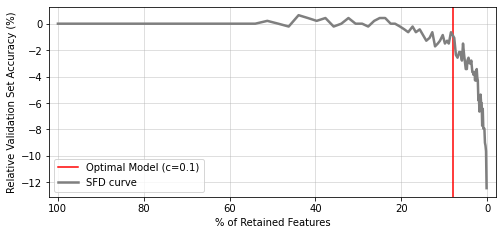

Optimal Model Size: 8.05% of full model


In [12]:
import matplotlib.pyplot as plt

percentage_vector = DetachMatrixModel._percentage_vector
acc_curve = DetachMatrixModel._sfd_curve

c = DetachMatrixModel.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100

point_x = x[DetachMatrixModel._max_index]
#point_y = y[DetachMatrixModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))